Epoch [1/10] - Avg Loss: 0.0183
Epoch [2/10] - Avg Loss: 0.0068
Epoch [3/10] - Avg Loss: 0.0054
Epoch [4/10] - Avg Loss: 0.0019
Epoch [5/10] - Avg Loss: 0.0014
Epoch [6/10] - Avg Loss: 0.0012
Epoch [7/10] - Avg Loss: 0.0010
Epoch [8/10] - Avg Loss: 0.0008
Epoch [9/10] - Avg Loss: 0.0006
Epoch [10/10] - Avg Loss: 0.0004

📊 Evaluation Metrics
MAE: 0.0122, RMSE: 0.0143, R²: 0.9686


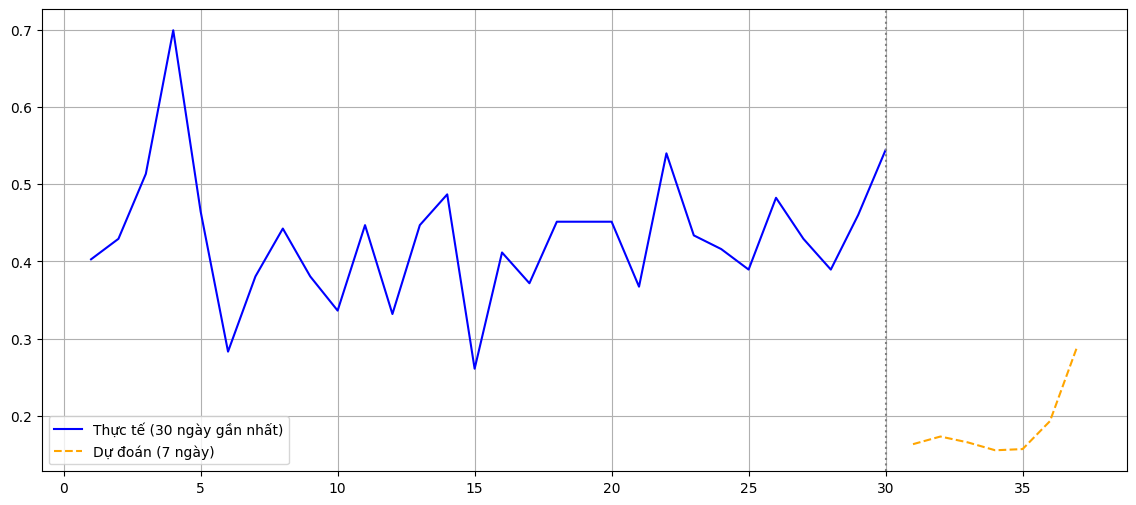

In [ ]:
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# ⚡ CONFIG
# ==========================================================
csv_files = sorted(glob.glob("data_chunks_2GB/*.csv"))[:30]
timesteps_in = 30
timesteps_out = 7
batch_size = 64
input_size = 8
target_size = 1
store_id = 0.0377358490566037
family_id = 0.46875
feature_cols = [
    'onpromotion_scaled', 'year_scaled',
    'month_sin', 'month_cos',
    'day_sin', 'day_cos',
    'family_scaled', 'store_scaled'
]
target_col = 'sales_scaled'

# ==========================================================
# ⚡ SCALER INIT
# ==========================================================
df_raw = pd.read_csv(csv_files[0]).dropna()
scaler = MinMaxScaler().fit(df_raw[feature_cols])

# ==========================================================
# ⚡ DATASET
# ==========================================================
class ChunkedTimeSeriesDataset(Dataset):
    def __init__(self, csv_files, timesteps_in, timesteps_out,
                 feature_cols, target_col, scaler,
                 store_id, family_id):

        self.csv_files = csv_files
        self.timesteps_in = timesteps_in
        self.timesteps_out = timesteps_out
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.scaler = scaler
        self.store_id = store_id
        self.family_id = family_id
        self.buffer = []
        self.file_idx = 0
        self.chunk_iter = None
        self._load_next_chunk()

    def _load_next_chunk(self):
        while self.file_idx < len(self.csv_files):
            file = self.csv_files[self.file_idx]
            self.chunk_iter = pd.read_csv(file, chunksize=100_000)
            self.file_idx += 1
            try:
                chunk = next(self.chunk_iter).dropna()
                chunk = chunk[(chunk['store_scaled'] == self.store_id) &
                              (chunk['family_scaled'] == self.family_id)]
                if chunk.empty:
                    continue
                scaled_features = self.scaler.transform(chunk[self.feature_cols])
                targets = chunk[self.target_col].values.reshape(-1, 1)
                self.buffer = np.hstack((targets, scaled_features)).tolist()
            except StopIteration:
                continue

    def __getitem__(self, idx):
        while len(self.buffer) < self.timesteps_in + self.timesteps_out:
            self._load_next_chunk()
            if len(self.buffer) < self.timesteps_in + self.timesteps_out:
                return self.__getitem__(idx + 1)

        start = np.random.randint(0, len(self.buffer) - (self.timesteps_in + self.timesteps_out))
        window = np.array(self.buffer[start:start + self.timesteps_in + self.timesteps_out])

        src = torch.tensor(window[:self.timesteps_in, 1:], dtype=torch.float32)
        tgt = torch.tensor(window[self.timesteps_in:, 0:1], dtype=torch.float32)

        return src, tgt

    def __len__(self):
        return int(1e5)

# ==========================================================
# ⚡ POSITIONAL ENCODING
# ==========================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # ✅ Đăng ký như buffer thay thế
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


# ==========================================================
# ⚡ ENCODER–DECODER MODEL
# ==========================================================
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, target_size,
                 d_model=64, nhead=4,
                 num_encoder_layers=2,
                 num_decoder_layers=2,
                 dim_feedforward=128,
                 dropout=0.1,
                 max_len=5000):

        super().__init__()

        self.input_proj = nn.Linear(input_size, d_model)
        self.target_proj = nn.Linear(target_size, d_model)

        self.pos_encoder = PositionalEncoding(d_model, max_len)

        enc_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                               nhead=nhead,
                                               dim_feedforward=dim_feedforward,
                                               dropout=dropout,
                                               batch_first=True)

        dec_layer = nn.TransformerDecoderLayer(d_model=d_model,
                                               nhead=nhead,
                                               dim_feedforward=dim_feedforward,
                                               dropout=dropout,
                                               batch_first=True)

        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_encoder_layers)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=num_decoder_layers)

        self.fc_out = nn.Linear(d_model, target_size)

    def forward(self, src, tgt):
        enc_in = self.input_proj(src)
        enc_in = self.pos_encoder(enc_in)
        memory = self.encoder(enc_in)

        dec_in = self.target_proj(tgt)
        dec_in = self.pos_encoder(dec_in)

        output = self.decoder(dec_in, memory)
        return self.fc_out(output)

# ==========================================================
# ⚡ TRAINING LOOP
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ChunkedTimeSeriesDataset(csv_files, timesteps_in, timesteps_out,
                                   feature_cols, target_col, scaler,
                                   store_id, family_id)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = TimeSeriesTransformer(input_size=input_size, target_size=target_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(10):  # Demo
    model.train()
    total_loss = 0
    for i, (src, tgt) in enumerate(loader):
        src = src.to(device)
        tgt = tgt.to(device)

        # Target input (shifted by one) để teacher forcing
        tgt_in = torch.cat([
            torch.zeros_like(tgt[:, :1, :]),
            tgt[:, :-1, :]
        ], dim=1)

        optimizer.zero_grad()
        pred = model(src, tgt_in)
        loss = criterion(pred, tgt)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i >= 500:
            break
    avg_loss = total_loss / (i + 1)
    print(f"Epoch [{epoch + 1}/10] - Avg Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), f"transformer_store{store_id}_family{family_id}.pth")

# ==========================================================
# ⚡ EVALUATION
# ==========================================================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for i, (src, tgt) in enumerate(loader):
        src = src.to(device)
        tgt_in = torch.cat([torch.zeros_like(tgt[:, :1, :]).to(device),
                            tgt[:, :-1, :].to(device)], dim=1)

        pred = model(src, tgt_in)

        y_true.extend(tgt.cpu().numpy().reshape(-1))
        y_pred.extend(pred.cpu().numpy().reshape(-1))
        if i >= 500:
            break

min_y, scale_y = scaler.min_[0], scaler.scale_[0]
y_true = np.array(y_true) * scale_y + min_y
y_pred = np.array(y_pred) * scale_y + min_y

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\n📊 Evaluation Metrics")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# ==========================================================
# ⚡ MULTI-STEP INFERENCE
# ==========================================================
model.eval()
with torch.no_grad():
    last_window = np.array(dataset.buffer[-timesteps_in:])  # ✅ Chuyển sang numpy
    src_seq = torch.tensor(last_window[:, 1:], dtype=torch.float32).unsqueeze(0).to(device)
    tgt_seq = torch.zeros((1, timesteps_out, 1), device=device)

    pred = model(src_seq, tgt_seq).squeeze().cpu().numpy()
    pred = pred * scale_y + min_y

    true_last_30 = np.array([row[0] for row in dataset.buffer[-30:]]) * scale_y + min_y

# ==========================================================
# ⚡ PLOTTING
# ==========================================================
plt.figure(figsize=(14, 6))
steps = np.arange(1, 30 + timesteps_out + 1)

plt.plot(np.arange(1, 31), true_last_30, label="Thực tế (30 ngày gần nhất)", color="blue")
plt.plot(np.arange(31, 31 + timesteps_out), pred, label=f"Dự đoán ({timesteps_out} ngày)", color="orange", linestyle="--")
plt.axvline(x=30, color='gray', linestyle=':')
plt.legend()
plt.grid(True)
plt.show()



📊 Evaluation Metrics
MAE: 0.0122, RMSE: 0.0143, R²: 0.9687


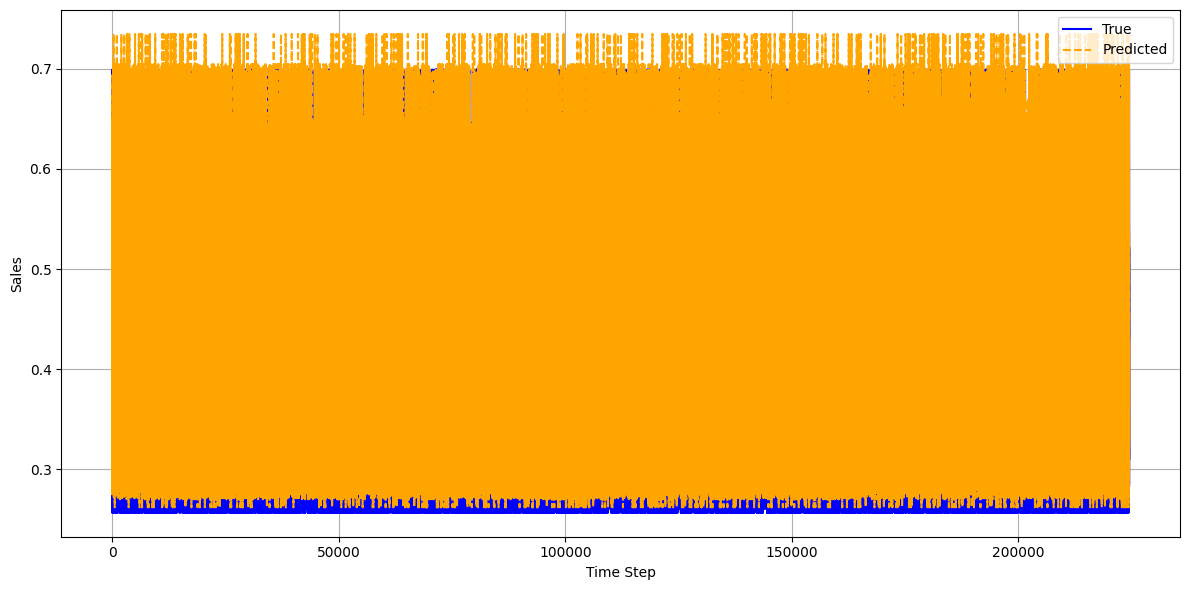

In [7]:
# ==========================================================
# ⚡ EVALUATION
# ==========================================================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for i, (src, tgt) in enumerate(loader):
        src = src.to(device)
        tgt_in = torch.cat([torch.zeros_like(tgt[:, :1, :]).to(device),
                            tgt[:, :-1, :].to(device)], dim=1)

        pred = model(src, tgt_in)

        y_true.extend(tgt.cpu().numpy().reshape(-1))
        y_pred.extend(pred.cpu().numpy().reshape(-1))
        if i >= 500:
            break

min_y, scale_y = scaler.min_[0], scaler.scale_[0]
y_true = np.array(y_true) * scale_y + min_y
y_pred = np.array(y_pred) * scale_y + min_y

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\n📊 Evaluation Metrics")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# ==========================================================
# ⚡ PLOTTING True vs Predicted
# ==========================================================
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True', color='blue')
plt.plot(y_pred, label='Predicted', color='orange', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
